# LSTM and GRU Implementations

The following notebook is used to implement the RNN model of LSTM and GRU on our training data. We will be training the data by sequences of individual players on a given play.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import torch
import warnings
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [24]:
#Read in all tracking
tracking_1 = pd.read_csv("../../Data/tracking_week_1.csv")
tracking = tracking_1
# tracking_2 = pd.read_csv("../../Data/tracking_week_2.csv")
# tracking_3 = pd.read_csv("../../Data/tracking_week_3.csv")
# tracking_4 = pd.read_csv("../../Data/tracking_week_4.csv")
# tracking_5 = pd.read_csv("../../Data/tracking_week_5.csv")
# tracking_6 = pd.read_csv("../../Data/tracking_week_6.csv")
# tracking_7 = pd.read_csv("../../Data/tracking_week_7.csv")
# tracking_8 = pd.read_csv("../../Data/tracking_week_8.csv")
# tracking_9 = pd.read_csv("../../Data/tracking_week_9.csv")

#tracking = pd.concat([tracking_1,tracking_2,tracking_3,tracking_4,tracking_5,tracking_6,tracking_7,tracking_8,tracking_9], axis = 0).reset_index(drop = True)

In [2]:
plays = pd.read_csv("../../Data/plays.csv")

In [3]:
#import pandas as pd
train_samp = pd.read_csv("../../Data/train_sample.csv")
players = pd.read_csv("../../Data/players.csv")

In [4]:
#take sample from train_samp
train_samp = train_samp[train_samp["gameId"]==2022090800]

In [5]:
display(train_samp)

,gameId,playId,nflId,frameId,x,y,unitDir,unitO,force,home,preSnapWinProbabilityDefense,bcx,bcy,bcs,bca,bco,bcdir,bcweight,bcPosition,bcForce,play_type,c1Dist,c2Dist,c3Dist,c4Dist,c5Dist,c6Dist,c7Dist,c8Dist,c9Dist,c10Dist,bcDist,c1Ang,c2Ang,c3Ang,c4Ang,c5Ang,c6Ang,c7Ang,c8Ang,c9Ang,c10Ang,bcAng,a,s,tackles_ingame,assists_ingame,ff_ingame,misses_ingame,tackle_efficiency_ingame,tackle_rating_ingame,rolling_tackles,rolling_assists,rolling_ff,rolling_mt,DL,LB,DB,QB,RB,WR,TE,OL,tackle_binary_all,tackle_binary_single,tackle_nonbinary_all,tackle_nonbinary_single,down,yardsToGo,defendersInTheBox,offenseFormation,absoluteYardlineNumber,timeSinceStart,surface,inside_outside,presnapDefScoreDiff,weight,position,gamePlayId
0,2.022091e+09,56.0,38577.0,6.0,41.89,28.740000,87.71,79.47,288.200000,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,3.195387,10.116071,10.461855,10.882909,12.035414,12.635874,12.701657,13.169210,14.799963,23.582173,7.067538,75.239538,89.059902,122.727777,103.094000,104.570954,166.159966,86.642246,80.903275,77.812451,158.729540,16.542527,2.62,3.35,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,242,ILB,2022090800.056.0
1,2.022091e+09,56.0,41239.0,6.0,27.85,29.960000,247.65,276.16,364.000000,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,1.400321,1.783620,2.496898,3.993257,4.414386,4.674409,8.228657,17.168183,21.436532,32.008038,13.527265,113.577579,163.037991,150.980380,102.982031,53.447313,68.130076,59.944064,110.580937,72.972206,65.058378,136.944687,2.86,3.62,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,280,DT,2022090800.056.0
2,2.022091e+09,56.0,42816.0,6.0,49.38,7.660000,8.33,61.57,346.254545,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,1.233207,10.014569,22.204274,22.838312,26.325539,26.712411,27.894992,30.064028,31.255438,33.017583,29.415605,89.937075,111.358111,93.020417,127.965101,125.346367,127.777247,120.762863,123.703959,122.414454,123.035494,99.957121,4.14,2.60,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,184,CB,2022090800.056.0
3,2.022091e+09,56.0,43294.0,6.0,41.85,37.850000,268.50,230.96,116.290909,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,8.993442,13.196030,14.422794,14.850576,15.279797,15.418982,16.539265,16.979061,21.643128,32.342421,2.828003,22.070958,48.171854,61.668459,56.543692,67.764015,42.186107,43.622479,30.430267,8.319643,15.291336,35.450938,1.23,5.88,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,1,0,1.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,208,CB,2022090800.056.0
4,2.022091e+09,56.0,43298.0,6.0,27.89,33.140000,293.53,249.12,241.090909,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,0.773886,2.104305,3.431049,5.466160,7.240836,7.311580,10.903687,17.517377,23.554390,34.387191,12.502404,48.770529,7.667234,0.177919,21.988835,3.672038,5.689796,3.646058,54.242746,21.039989,15.533146,77.770945,2.21,1.34,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,240,DE,2022090800.056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,2.022091e+09,3283.0,47939.0,63.0,88.53,19.633333,241.17,162.23,118.363636,1,0.001342,90.62,21.363333,1.99,1.92,242.87,202.99,203,RB,177.163636,run,1.454545,1.654237,2.241540,2.306274,2.505115,4.101622,4.672740,5.960285,10.247819,19.561851,2.713116,168.570511,133.939947,143.220641,65.397219,32.491936,170.090869,169.997845,74.063744,15.458222,144.771587,158.446298,1.05,0.31,2,0,0,1,0.666667,0.666667,0.0,0.0,0.0,0.0,4,3,4,1,2,2,1

In [6]:
#Run the model prep notebok
%run Model_prep.ipynb

In [7]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.sigmoid(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [8]:
def train_nn(train_loader, learn_rate = 0.01,batch_size=1000, hidden_dim=256, EPOCHS=5, model_type="GRU", num_classes = 2):
    
    #Define class weights
    class_counts = [0]*num_classes
    
    # Iterate through the training data to count class occurrences
    for _, labels in train_loader:
        for label in labels.view(-1, 140):
            for frame_label in label:
                class_counts[frame_label] += 1
            
    total_samples = sum(class_counts)
    class_weights = [total_samples/(num_classes*count) for count in class_counts]
    class_weights = torch.tensor(class_weights)
    
    print("Calculated training weights")
    print(class_weights)
    
    
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = next(iter(train_loader))[1].shape[1]
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight = class_weights[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            out = out.squeeze()
            labels = label.view(-1,1).to(device).float()
            loss = criterion(out, label.to(device).float())
            loss.mean()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_loader):
    model.eval()
    outputs = []
    targets = []
    start_time = time.time()
    for x, label in test_loader:
        out, _ = model(x.to(device).float(), None)
        out = out.squeeze()
        outputs.append(out.cpu().detach().numpy())
        targets.append(label.numpy())

    print("Evaluation Time: {}".format(str(time.time()-start_time)))
    
    # Calculate log loss (cross-entropy loss) for classification
    log_losses = []
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate log loss (cross-entropy loss) for classification
    log_losses = []
    for i in range(len(outputs)):
        labels = torch.from_numpy(targets[i]).float()
        log_loss_value = criterion(torch.from_numpy(outputs[i]), labels)
        log_losses.append(log_loss_value.item())

    avg_log_loss = np.mean(log_losses)
    print("Average Log Loss: {}".format(avg_log_loss))
    return avg_log_loss,outputs

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
x, y, mask, id_data = data_tensors_rnn_3d(train_samp, "tackle_binary_single")

In [11]:
print(x.shape)
print(y.shape)
print(mask.shape)

torch.Size([154, 140, 77])
torch.Size([154, 140])
torch.Size([154, 140])


In [12]:
batch_size = 77
train_data = TensorDataset(x,y)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [13]:
gru_model = train_nn(train_loader, batch_size = batch_size, EPOCHS = 3, model_type="GRU")
#Lstm_model = train_nn(train_loader, batch_size = batch_size, model_type="LSTM")

Calculated training weights
tensor([5.0042e-01, 5.9889e+02])
Starting Training of GRU model
Epoch 1/3 Done, Total Loss: 0.9422272145748138
Total Time Elapsed: 1.1833889484405518 seconds
Epoch 2/3 Done, Total Loss: 0.9910629391670227
Total Time Elapsed: 1.1142990589141846 seconds
Epoch 3/3 Done, Total Loss: 0.5913622975349426
Total Time Elapsed: 1.08854341506958 seconds
Total Training Time: 3.3862314224243164 seconds


In [14]:
avg_log_loss_gru,outputs_gru = evaluate(gru_model, train_loader)
#avg_log_loss_lstm, outputs_lstm = evaluate(Lstm_model, train_loader)

Evaluation Time: 0.6448838710784912
Average Log Loss: 0.26068177074193954


In [15]:
# Example flattened mask as a tensor
flattened_mask = mask.view(-1)
# Create a flattened mask as a list of True and False values
flattened_mask = (flattened_mask == 1).tolist()

In [16]:
#Flattening those GRU values to get outputs with right values
flattened_values_gru = np.concatenate(outputs_gru).ravel()
# Create a new DataFrame from the flattened array
df_flattened_gru = pd.DataFrame(flattened_values_gru, columns=['model_probs_GRU'])
#concatenate the probs with the id data
pred_df_gru = pd.concat([id_data, df_flattened_gru], axis=1)
pred_df_gru = pred_df_gru[flattened_mask]

In [17]:
display(pred_df_gru)

,gamePlayId,nflId,frameId,model_probs_GRU
0,2022090800.01187.0,37075.0,19.0,0.393843
1,2022090800.01187.0,37075.0,20.0,0.216804
2,2022090800.01187.0,37075.0,21.0,-0.467800
3,2022090800.01187.0,37075.0,22.0,-0.763703
4,2022090800.01187.0,37075.0,23.0,-0.596863
...,...,...,...,...
21283,2022090800.0980.0,52607.0,9.0,0.358489
21420,2022090800.0980.0,53532.0,6.0,1.014018
21421,2022090800.0980.0,53532.0,7.0,0.774009
21422,2022090800.0980.0,53532.0,8.0,0.223243


In [173]:
# #Flattening those LSTM values to get outputs with right values
# flattened_values_lstm = np.concatenate(outputs_lstm).ravel()
# # Create a new DataFrame from the flattened array
# df_flattened_lstm = pd.DataFrame(flattened_values_lstm, columns=['model_probs_LSTM'])
# #concatenate the probs with the id data
# pred_df_lstm = pd.concat([id_data, df_flattened_lstm], axis=1)
# pred_df_lstm = pred_df_lstm[flattened_mask]

In [226]:
# display(pred_df_lstm)

,gamePlayId,nflId,frameId,model_probs_LSTM
0,2022090800.01187.0,37075.0,19.0,0.000004
1,2022090800.01187.0,37075.0,20.0,0.000077
2,2022090800.01187.0,37075.0,21.0,0.353301
3,2022090800.01187.0,37075.0,22.0,0.000365
4,2022090800.01187.0,37075.0,23.0,0.984642
...,...,...,...,...
2015738,2022110700.0378.0,54541.0,37.0,0.999793
2015739,2022110700.0378.0,54541.0,38.0,0.999986
2015740,2022110700.0378.0,54541.0,39.0,0.999968
2015741,2022110700.0378.0,54541.0,40.0,0.999871


In [18]:
def softmax(dataframe):
    # Group the data by gamePlayId and frameId
    grouped = dataframe.groupby(['gamePlayId', 'frameId'])
    
    # Initialize an empty DataFrame to store the results
    result_df = pd.DataFrame()
    
    # Iterate over groups
    for group_name, group_data in grouped:
        # Apply softmax to model_probs_GRU column within the group
        softmax_values = np.exp(group_data['model_probs_GRU']) / np.sum(np.exp(group_data['model_probs_GRU']))
        
        # Add the softmax values to the group_data as a new column
        group_data['softmax_probs'] = softmax_values
        
        # Append the updated group_data to the result DataFrame
        result_df = pd.concat([result_df, group_data])
    
    return result_df

In [19]:
pred_df_gru = softmax(pred_df_gru)

In [20]:
display(pred_df_gru[(pred_df_gru["gamePlayId"]=="2022090800.01187.0")&(pred_df_gru["frameId"]==40)])

,gamePlayId,nflId,frameId,model_probs_GRU,softmax_probs
21,2022090800.01187.0,37075.0,40.0,-0.296166,0.077751
161,2022090800.01187.0,40107.0,40.0,0.162447,0.122992
301,2022090800.01187.0,40166.0,40.0,0.124909,0.118461
441,2022090800.01187.0,41341.0,40.0,-0.275657,0.079362
581,2022090800.01187.0,44976.0,40.0,0.036706,0.108460
721,2022090800.01187.0,46085.0,40.0,0.015228,0.106155
861,2022090800.01187.0,46190.0,40.0,-0.301303,0.077352
1001,2022090800.01187.0,47792.0,40.0,-0.279241,0.079078
1141,2022090800.01187.0,52647.0,40.0,-0.166463,0.088518
1281,2022090800.01187.0,53459.0,40.0,-0.346338,0.073946


In [37]:
pred_df_gru[(pred_df_gru["gamePlayId"]=="2022090800.01187.0")&(pred_df_gru["frameId"]==40)]["softmax_probs"].sum()

1.0

In [32]:
display(train_samp[(train_samp["gamePlayId"]=="2022090800.01187.0")&(train_samp["frameId"]==51)])

,gameId,playId,nflId,frameId,x,y,unitDir,unitO,force,home,preSnapWinProbabilityDefense,bcx,bcy,bcs,bca,bco,bcdir,bcweight,bcPosition,bcForce,play_type,c1Dist,c2Dist,c3Dist,c4Dist,c5Dist,c6Dist,c7Dist,c8Dist,c9Dist,c10Dist,bcDist,c1Ang,c2Ang,c3Ang,c4Ang,c5Ang,c6Ang,c7Ang,c8Ang,c9Ang,c10Ang,bcAng,a,s,tackles_ingame,assists_ingame,ff_ingame,misses_ingame,tackle_efficiency_ingame,tackle_rating_ingame,rolling_tackles,rolling_assists,rolling_ff,rolling_mt,DL,LB,DB,QB,RB,WR,TE,OL,tackle_binary_all,tackle_binary_single,tackle_nonbinary_all,tackle_nonbinary_single,down,yardsToGo,defendersInTheBox,offenseFormation,absoluteYardlineNumber,timeSinceStart,surface,inside_outside,presnapDefScoreDiff,weight,position,gamePlayId
1452,2.022091e+09,1187.0,37075.0,51.0,54.13,39.13,69.34,163.96,84.090909,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,1.290310,1.922342,2.051170,2.535271,2.540177,2.630475,3.726513,4.348758,6.226155,19.990250,0.715891,173.699337,133.623773,119.284074,80.859056,105.533207,24.648039,65.986158,155.939489,149.257389,166.238571,175.884859,0.74,4.99,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,5,1,1,3,1,5,1,1,1.0,1.0,1,10,6.0,SINGLEBACK,70,1272,turf,inside,10,250,OLB,2022090800.01187.0
1453,2.022091e+09,1187.0,40107.0,51.0,58.70,34.36,97.69,117.63,248.040909,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,3.736308,4.128353,4.560976,6.025156,7.149434,7.507063,7.812765,9.066080,10.331529,19.728540,6.378973,103.655787,29.929364,37.754144,46.562287,14.498336,49.932466,69.892554,40.618729,36.643344,118.755879,42.078916,2.77,3.41,1,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,3,3,5,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SINGLEBACK,70,1272,turf,inside,10,197,FS,2022090800.01187.0
1454,2.022091e+09,1187.0,40166.0,51.0,58.99,38.41,133.39,168.96,236.145455,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,2.916248,3.640618,3.942715,5.207043,6.594012,6.630068,7.332394,8.219227,8.267001,22.579604,5.160475,62.123594,60.111855,5.929894,52.451980,101.738992,46.869255,30.943675,22.633355,63.269414,90.910212,45.832779,2.72,2.50,2,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,3,3,5,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SINGLEBACK,70,1272,turf,inside,10,191,SS,2022090800.01187.0
1455,2.022091e+09,1187.0,41341.0,51.0,53.31,37.67,34.20,30.12,86.354545,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,0.542310,1.186002,2.142825,2.770289,2.870279,3.050049,4.265232,4.471610,5.045493,18.322972,0.962549,11.417594,109.026722,37.142520,178.157421,34.998496,82.701093,16.699625,79.957637,101.955754,159.086989,23.100539,0.59,2.45,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,5,1,1,3,1,5,1,1,0.5,0.5,1,10,6.0,SINGLEBACK,70,1272,turf,inside,10,322,DT,2022090800.01187.0
1456,2.022091e+09,1187.0,44976.0,51.0,54.41,36.92,112.91,114.58,96.295455,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,1.132078,1.221147,1.907092,2.516764,3.453983,4.002812,4.265126,4.360241,5.649230,18.385179,1.664332,9.095383,81.302498,91.052801,31.631716,81.850449,168.764869,12.643294,44.296584,8.332058,118.050562,2.515124,0.95,2.50,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,5,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SINGLEBACK,70,1272,turf,inside,10,223,OLB,2022090800.01187.0
1457,2.022091e+09,1187.0,46085.0,51.0,56.55,35.88,112.23,156.11,322.727273,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,1.788687,2.008084,3.172270,3.392285,4.879150,5.129571,5.482335,6.456353,7.756404,19.066620,3.762765,10.291850,10.985251,132.982245,31.643284,36.947217,16.074832,66.097606,23.460277,18.587625,111.750005,24.062167,2.84,0.61,2,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,3,3,5,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SINGLEBACK,70,1272,turf,inside,10,250,ILB,2022090800.01187.0
1458,2.022091e+09,1187.0,46190.0,51.0,52.07,35.31,43.70,75.01,142.254545,0,0.792763,53.83,38.48,3.03,4.32,327.06,33.06,200,RB,392.727273,run,1.238103,3.083667,3.103627,3.906226,4.060406,4.719587,5.081929,6.466970,6.898826,15.681406,3.625810,100.170556,40.903708,12.200318,79.953838,10.049069,14.256276,47.878618,51.5

In [35]:
display(pred_df_gru)

,gamePlayId,nflId,frameId,model_probs_GRU,softmax_probs
0,2022090800.01187.0,37075.0,19.0,-0.184859,0.038864
140,2022090800.01187.0,40107.0,19.0,0.351262,0.066432
280,2022090800.01187.0,40166.0,19.0,1.383535,0.186504
420,2022090800.01187.0,41341.0,19.0,0.091229,0.051221
560,2022090800.01187.0,44976.0,19.0,1.145309,0.146970
...,...,...,...,...,...
20863,2022090800.0980.0,47844.0,9.0,-0.586415,0.112271
21003,2022090800.0980.0,47917.0,9.0,-1.938212,0.029053
21143,2022090800.0980.0,52492.0,9.0,-1.148091,0.064023
21283,2022090800.0980.0,52607.0,9.0,-0.491691,0.123426


In [67]:
#Select a gamePlayId
specific_play = pred_df_gru[pred_df_gru["gamePlayId"]=="2022090800.01187.0"]
display(specific_play)

,gamePlayId,nflId,frameId,model_probs_GRU,softmax_probs
0,2022090800.01187.0,37075.0,19.0,-0.184859,0.038864
140,2022090800.01187.0,40107.0,19.0,0.351262,0.066432
280,2022090800.01187.0,40166.0,19.0,1.383535,0.186504
420,2022090800.01187.0,41341.0,19.0,0.091229,0.051221
560,2022090800.01187.0,44976.0,19.0,1.145309,0.146970
...,...,...,...,...,...
872,2022090800.01187.0,46190.0,51.0,-1.873433,0.030376
1012,2022090800.01187.0,47792.0,51.0,-0.872308,0.082663
1152,2022090800.01187.0,52647.0,51.0,-0.054943,0.187192
1292,2022090800.01187.0,53459.0,51.0,-1.064479,0.068210


(<Figure size 1200x633 with 1 Axes>, <AxesSubplot:>)

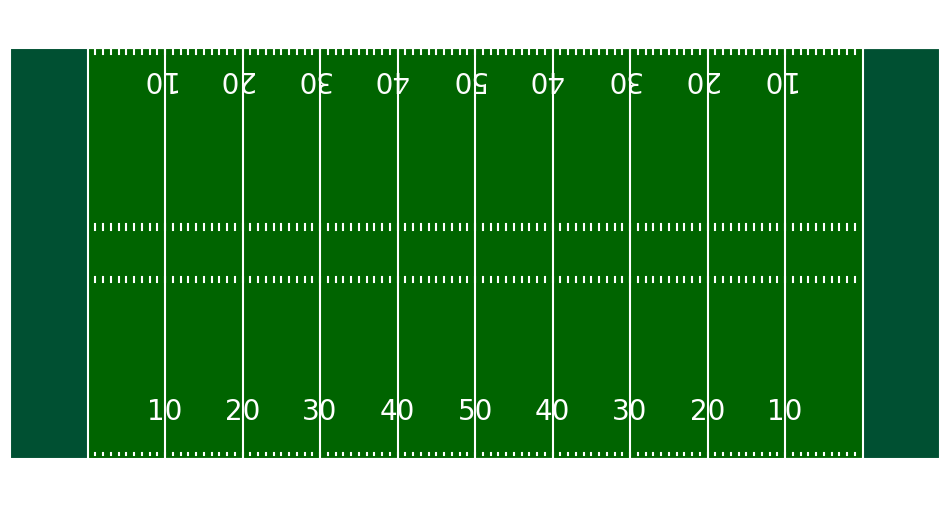

In [65]:
#Run the trackingDataviz notebook
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()

In [75]:
def animate_player_movement(preds_data, tracking_data, plays, gameId="", playId="", pred_column="softmax_probs"):
    """
    Animates the player movement for the given game and play ID within a Jupyter notebook.
    """
    %matplotlib inline
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML

    # Split the string at the periods and expand into separate columns
    preds_data[['gameId', 'playId', 'extra']] = preds_data['gamePlayId'].str.split('.', expand=True)

    # Convert the first two new columns to float
    preds_data['gameId'] = preds_data['gameId'].astype(float)
    preds_data['playId'] = preds_data['playId'].astype(float)

    if gameId == "":
        gameId = tracking_data['gameId'].unique()[0]
        playId = tracking_data['playId'].unique()[0]

    # Subset the tracking data to the gameId and playId
    tracking_data = tracking_data[(tracking_data['gameId'] == gameId) & (tracking_data['playId'] == playId)]
    preds_data = preds_data[(preds_data['gameId'] == gameId) & (preds_data['playId'] == playId)]
    plays = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)]

    # Obtain ball carrier ID and offensive team
    ball_carrier = plays["ballCarrierId"].iloc[0]
    offense_team = plays["possessionTeam"].iloc[0]

    # Merge data
    play_data = tracking_data.merge(preds_data, on=["gameId", "playId", "frameId", "nflId"], how="left")
    
    # Change the frameId to int and sort the data
    play_data["frameId"] = play_data["frameId"].astype(int)
    play_data = play_data.sort_values(by='frameId')

    # Filter out frames where all 'softmax_probs' values are NA
    play_data = play_data.groupby('frameId').filter(lambda x: not x[pred_column].isna().all())

    # Create the football field
    fig, ax = create_football_field()


    # Initialize the scatter plot for player positions on top of the football field
    scat = ax.scatter([], [], s=40, color=[], zorder=5)

    # Initialize a second scatter plot for the transparent points
    transparent_scat = ax.scatter([], [], s=[], color='blue', alpha=0.25, zorder=4)

    def update(frame_number):
        # Update player and ball positions for the given frame
        frame_data = play_data[play_data.frameId == frame_number]

        # Lists for original scatter plot properties
        positions = []
        colors = []

        # Initialize a list for the sizes of the transparent points
        sizes = []
        positions_offense = []



        for index, row in frame_data.iterrows():
            positions.append([row['x'], row['y']])
            
            # Determine color based on team and ball carrier
            if row['nflId'] == ball_carrier:
                colors.append('black')
            elif row['club'] == offense_team:
                colors.append('red')
            else:
                colors.append('blue')


            # Determine size based on softmax_probs for defensive players
            if row['club'] != offense_team:
                #append offensive players
                positions_offense.append([row['x'],row['y']])
                # Adjust size based on softmax_probs, with a scaling factor for visibility
                size = row[pred_column] * 500 + 500  # Example scaling factor
                sizes.append(size)
            else:
                sizes.append(0)  # Offensive players remain the same size



        # Update the original scatter plot
        scat.set_offsets(positions)
        scat.set_color(colors)

        #update the original predictions
        transparent_scat.set_offsets(positions_offense)
        transparent_scat.set_sizes(sizes)

        return scat,transparent_scat

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(play_data.frameId.min(), play_data.frameId.max() + 1), interval=700, blit=True)

    # Use HTML to create a video within the notebook
    return HTML(anim.to_html5_video())


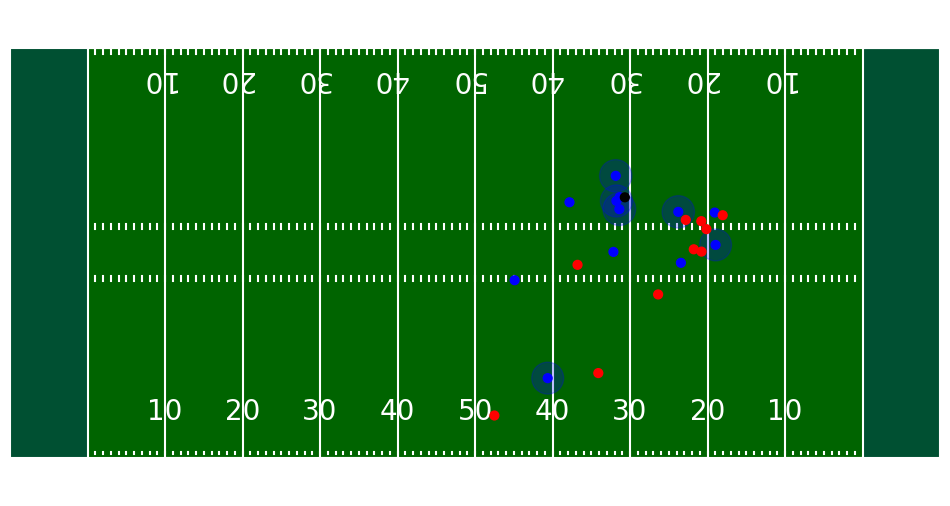

In [76]:
animate_player_movement(pred_df_gru, tracking, plays)

In [71]:
display(train_samp)

,gameId,playId,nflId,frameId,x,y,unitDir,unitO,force,home,preSnapWinProbabilityDefense,bcx,bcy,bcs,bca,bco,bcdir,bcweight,bcPosition,bcForce,play_type,c1Dist,c2Dist,c3Dist,c4Dist,c5Dist,c6Dist,c7Dist,c8Dist,c9Dist,c10Dist,bcDist,c1Ang,c2Ang,c3Ang,c4Ang,c5Ang,c6Ang,c7Ang,c8Ang,c9Ang,c10Ang,bcAng,a,s,tackles_ingame,assists_ingame,ff_ingame,misses_ingame,tackle_efficiency_ingame,tackle_rating_ingame,rolling_tackles,rolling_assists,rolling_ff,rolling_mt,DL,LB,DB,QB,RB,WR,TE,OL,tackle_binary_all,tackle_binary_single,tackle_nonbinary_all,tackle_nonbinary_single,down,yardsToGo,defendersInTheBox,offenseFormation,absoluteYardlineNumber,timeSinceStart,surface,inside_outside,presnapDefScoreDiff,weight,position,gamePlayId
0,2.022091e+09,56.0,38577.0,6.0,41.89,28.740000,87.71,79.47,288.200000,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,3.195387,10.116071,10.461855,10.882909,12.035414,12.635874,12.701657,13.169210,14.799963,23.582173,7.067538,75.239538,89.059902,122.727777,103.094000,104.570954,166.159966,86.642246,80.903275,77.812451,158.729540,16.542527,2.62,3.35,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,242,ILB,2022090800.056.0
1,2.022091e+09,56.0,41239.0,6.0,27.85,29.960000,247.65,276.16,364.000000,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,1.400321,1.783620,2.496898,3.993257,4.414386,4.674409,8.228657,17.168183,21.436532,32.008038,13.527265,113.577579,163.037991,150.980380,102.982031,53.447313,68.130076,59.944064,110.580937,72.972206,65.058378,136.944687,2.86,3.62,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,280,DT,2022090800.056.0
2,2.022091e+09,56.0,42816.0,6.0,49.38,7.660000,8.33,61.57,346.254545,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,1.233207,10.014569,22.204274,22.838312,26.325539,26.712411,27.894992,30.064028,31.255438,33.017583,29.415605,89.937075,111.358111,93.020417,127.965101,125.346367,127.777247,120.762863,123.703959,122.414454,123.035494,99.957121,4.14,2.60,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,184,CB,2022090800.056.0
3,2.022091e+09,56.0,43294.0,6.0,41.85,37.850000,268.50,230.96,116.290909,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,8.993442,13.196030,14.422794,14.850576,15.279797,15.418982,16.539265,16.979061,21.643128,32.342421,2.828003,22.070958,48.171854,61.668459,56.543692,67.764015,42.186107,43.622479,30.430267,8.319643,15.291336,35.450938,1.23,5.88,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,1,0,1.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,208,CB,2022090800.056.0
4,2.022091e+09,56.0,43298.0,6.0,27.89,33.140000,293.53,249.12,241.090909,1,0.413347,40.15,35.590000,4.61,4.82,245.73,157.80,191,WR,418.463636,pass,0.773886,2.104305,3.431049,5.466160,7.240836,7.311580,10.903687,17.517377,23.554390,34.387191,12.502404,48.770529,7.667234,0.177919,21.988835,3.672038,5.689796,3.646058,54.242746,21.039989,15.533146,77.770945,2.21,1.34,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,3,2,6,1,1,3,1,5,0,0,0.0,0.0,1,10,6.0,SHOTGUN,85,0,turf,inside,0,240,DE,2022090800.056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382795,2.022111e+09,3299.0,46077.0,15.0,12.79,18.193333,316.93,310.26,108.727273,0,0.995175,18.98,12.923333,1.80,3.90,84.28,62.29,204,WR,361.636364,pass,3.984533,4.382237,5.707136,6.483949,7.567331,8.460715,10.242080,13.548432,28.643975,32.620414,8.129514,168.904899,131.239251,119.593791,123.840114,142.731481,132.325061,109.533515,71.450954,119.378206,93.568031,2.659818,1.04,3.33,1,3,0,0,1.0,0.625000,19.0,8.0,0.0,1.0,1,5,5,1,1,3,1,5,0,0,0.0,0.0,2,19,5.0,SH